In [54]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scripts import howard_cfv
from scripts import sahr_cfv
from scripts import bennet_cfv

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import ipywidgets as widgets


# Manual


In [55]:
ALTITUDE = 3048  # in m
SHEAR_MODULUS = 5000000000  # in Pa
THICKNESS = 4  # in mm
ROOT_CHORD = 300  # in mm
TIP_CHORD = 100  # in mm
SEMI_SPAN = 140  # in mm
SEA_LEVEL_SOUND = 340  # in m/s
SEA_LEVEL_PRESSURE = 101325  # in Pa
ATMOSPHERIC_SCALE_HEIGHT = 8077  # m
THICKNESS_INCREMENTS = 0.01 # in mm
MAXIMUM_THICKNESS = 5
MINIMUM_THICKNESS = 0
SWEEP_LENGTH = 90 #mm

UNITS = 'SI' # or 'IMPERIAL'

MAX_VELOCITY = 323


## SI to Imperial Conversion

In [56]:
METRES_TO_FEET = 3.28084
MILLIMETRES_TO_INCHES = 0.0393701
PA_TO_PSI=0.000145038

In [57]:
def get_parameters_for_functions(units='SI'):
    if units.upper() == 'SI':
        # Convert SI units to Imperial for howard_cfv
        altitude_howard = ALTITUDE * METRES_TO_FEET
        shear_modulus_howard = SHEAR_MODULUS * PA_TO_PSI
        thickness_howard = THICKNESS * MILLIMETRES_TO_INCHES
        root_chord_howard = ROOT_CHORD * MILLIMETRES_TO_INCHES
        tip_chord_howard = TIP_CHORD * MILLIMETRES_TO_INCHES
        semispan_howard = SEMI_SPAN * MILLIMETRES_TO_INCHES

        # Use SI units for sahr_cfv
        altitude_sahr = ALTITUDE
        shear_modulus_sahr = SHEAR_MODULUS
        thickness_sahr = THICKNESS
        root_chord_sahr = ROOT_CHORD
        tip_chord_sahr = TIP_CHORD
        semispan_sahr = SEMI_SPAN
        
        # Use SI units for bennet_cfv
        altitude_bennet = ALTITUDE
        shear_modulus_bennet = SHEAR_MODULUS/1000
        thickness_bennet = THICKNESS/10
        root_chord_bennet = ROOT_CHORD/10
        tip_chord_bennet = TIP_CHORD/10
        semispan_bennet = SEMI_SPAN/10
        sweep_length_bennet = SWEEP_LENGTH/10
        k_value_bennet = 1.4  # Specific heat ratio
        sea_level_pressure_bennet = SEA_LEVEL_PRESSURE/1000  # Standard pressure in kPa or psi

    elif units.upper() == 'IMPERIAL':
        # Use Imperial units for howard_cfv
        altitude_howard = ALTITUDE
        shear_modulus_howard = SHEAR_MODULUS
        thickness_howard = THICKNESS
        root_chord_howard = ROOT_CHORD
        tip_chord_howard = TIP_CHORD
        semispan_howard = SEMI_SPAN

        # Convert Imperial units to SI for sahr_cfv
        altitude_sahr = ALTITUDE
        shear_modulus_sahr = SHEAR_MODULUS
        thickness_sahr = THICKNESS
        root_chord_sahr = ROOT_CHORD
        tip_chord_sahr = TIP_CHORD
        semispan_sahr = SEMI_SPAN

    else:
        raise ValueError("Invalid unit system. Choose 'SI' or 'Imperial'.")

    return {
        'howard_cfv': {
            'altitude': altitude_howard,
            'shear_modulus': shear_modulus_howard,
            'thickness': thickness_howard,
            'root_chord': root_chord_howard,
            'tip_chord': tip_chord_howard,
            'semispan': semispan_howard
        },
        'sahr_cfv': {
            'sea_level_speed_of_sound': SEA_LEVEL_SOUND,
            'altitude': altitude_sahr,
            'atmospheric_scale_height': ATMOSPHERIC_SCALE_HEIGHT,
            'shear_modulus': shear_modulus_sahr,
            'sea_level_pressure': SEA_LEVEL_PRESSURE,
            'thickness': thickness_sahr,
            'root_chord': root_chord_sahr,
            'tip_chord': tip_chord_sahr,
            'semispan': semispan_sahr
        },
        'sahr_flutter_velocity_list': {
            # Exclude 'thickness' if it's not needed
            'sea_level_speed_of_sound': SEA_LEVEL_SOUND,
            'altitude': altitude_sahr,
            'atmospheric_scale_height': ATMOSPHERIC_SCALE_HEIGHT,
            'shear_modulus': shear_modulus_sahr,
            'sea_level_pressure': SEA_LEVEL_PRESSURE,
            'root_chord': root_chord_sahr,
            'tip_chord': tip_chord_sahr,
            'semispan': semispan_sahr
        },
        'bennet_cfv': {
            'unit_system': units.lower(),
            'cr_val': root_chord_bennet,
            'ct_val': tip_chord_bennet,
            'b_val': semispan_bennet,
            'h_val': altitude_bennet,
            't_val': thickness_bennet,
            'm_val': sweep_length_bennet,
            'G_val': shear_modulus_bennet,
            'K_val': k_value_bennet,
            'P0_val': sea_level_pressure_bennet
        }
    }


params = get_parameters_for_functions(UNITS)

# Howard Flutter Velocity


In [58]:
howard_result = howard_cfv(
    **params['howard_cfv']) / (METRES_TO_FEET if UNITS == 'SI' else 1)
print(howard_result)

402.31688469701913


# Sahr Flutter Velocity


In [59]:
sahr_result = sahr_cfv(**params['sahr_cfv'])
print(sahr_result)

401.84737525224915


# Bennet Flutter Velocity

In [60]:
bennet_result = bennet_cfv(**params['bennet_cfv'])
print(bennet_result)

292.903087888114


## Comparison of Flutter Velocities

In [61]:
# Create array of thickness values
thicknesses_array = np.arange(
    MINIMUM_THICKNESS, MAXIMUM_THICKNESS + THICKNESS_INCREMENTS, THICKNESS_INCREMENTS)

# altitude_array = np.arange(
#     MINIMUM_THICKNESS, MAXIMUM_THICKNESS + THICKNESS_INCREMENTS, THICKNESS_INCREMENTS)

In [62]:
howard_flutter_array = []
sahr_flutter_array= []
bennet_flutter_array = []

for thickness in thicknesses_array:
    # Update the thickness in the params for howard_cfv
    params['howard_cfv']['thickness'] = thickness * \
        MILLIMETRES_TO_INCHES if UNITS == 'SI' else thickness
        
    params['sahr_cfv']['thickness'] = thickness
    params['bennet_cfv']['t_val'] = thickness/10

    # Calculate flutter velocity for the current thickness
    flutter_velocity_howard = howard_cfv(**params['howard_cfv'])
    flutter_velocity_sahr = sahr_cfv(**params['sahr_cfv'])
    flutter_velocity_bennet = bennet_cfv(**params['bennet_cfv'])
    # Convert flutter velocity to the correct units if necessary
    flutter_velocity_converted = flutter_velocity_howard / \
        (METRES_TO_FEET if UNITS == 'SI' else 1)

    # Append the calculated flutter velocity to the array
    howard_flutter_array.append(flutter_velocity_converted)
    sahr_flutter_array.append(flutter_velocity_sahr)
    bennet_flutter_array.append(flutter_velocity_bennet)

howard_flutter_array = np.array(howard_flutter_array)
sahr_flutter_array = np.array(sahr_flutter_array)
bennet_flutter_array = np.array(bennet_flutter_array)

In [63]:
# lofv = list_of_flutter_velocities(
#     MINIMUM_THICKNESS, MAXIMUM_THICKNESS, THICKNESS_INCREMENTS, **params['sahr_flutter_velocity_list'])

In [64]:
df_dict = {
    "thickness": thicknesses_array,
    "howard_flutter_velocity": howard_flutter_array,
    "sahr_flutter_velocity": sahr_flutter_array,
    "bennet_flutter_velocity": bennet_flutter_array
}

# Creating the DataFrame
flutter_df = pd.DataFrame(df_dict)
display(flutter_df)

,thickness,howard_flutter_velocity,sahr_flutter_velocity,bennet_flutter_velocity
0,0.00,0.000000,0.000000,0
1,0.01,0.050290,0.050231,0.0366128859860143
2,0.02,0.142240,0.142075,0.103556879838082
3,0.03,0.261312,0.261008,0.190246136218510
4,0.04,0.402317,0.401847,0.292903087888114
...,...,...,...,...
496,4.96,555.521392,554.873091,404.442212877566
497,4.97,557.202243,556.551980,405.665940689115
498,4.98,558.884785,558.232559,406.890900235268
499,4.99,560.569018,559.914826,408.117090278719


In [65]:
flutter_df["howard_safety_factor"] = flutter_df['howard_flutter_velocity']/MAX_VELOCITY
flutter_df["sahr_safety_factor"] = flutter_df['sahr_flutter_velocity']/MAX_VELOCITY
flutter_df["bennet_safety_factor"] = flutter_df['bennet_flutter_velocity']/MAX_VELOCITY

display(flutter_df)

,thickness,howard_flutter_velocity,sahr_flutter_velocity,bennet_flutter_velocity,howard_safety_factor,sahr_safety_factor,bennet_safety_factor
0,0.00,0.000000,0.000000,0,0.000000,0.000000,0
1,0.01,0.050290,0.050231,0.0366128859860143,0.000156,0.000156,0.000113352588191995
2,0.02,0.142240,0.142075,0.103556879838082,0.000440,0.000440,0.000320609535102423
3,0.03,0.261312,0.261008,0.190246136218510,0.000809,0.000808,0.000588997325753900
4,0.04,0.402317,0.401847,0.292903087888114,0.001246,0.001244,0.000906820705535957
...,...,...,...,...,...,...,...
496,4.96,555.521392,554.873091,404.442212877566,1.719880,1.717873,1.25214307392435
497,4.97,557.202243,556.551980,405.665940689115,1.725084,1.723071,1.25593170491986
498,4.98,558.884785,558.232559,406.890900235268,1.730293,1.728274,1.25972414933520
499,4.99,560.569018,559.914826,408.117090278719,1.735508,1.733482,1.26352040333969


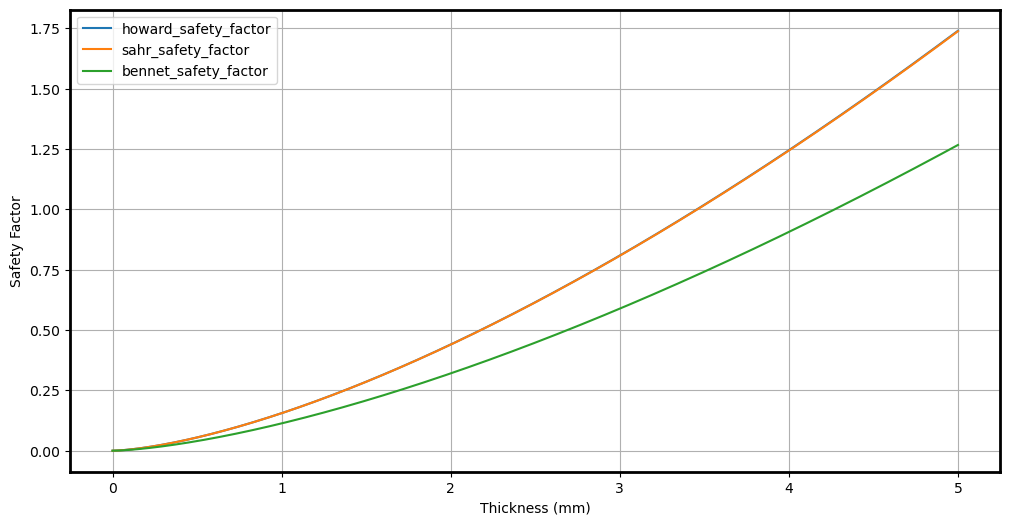

In [66]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.set_xlabel("Thickness (mm)")
ax.set_ylabel("Safety Factor")
ax.grid(True)

# Plot each safety factor column against thickness
for column in ['howard_safety_factor', 'sahr_safety_factor', 'bennet_safety_factor']:
    ax.plot(flutter_df['thickness'], flutter_df[column], label=column)

# Change line styles if needed, here they are all solid by default

# Change spine properties
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

# Adding a legend to distinguish between different safety factors
ax.legend()

plt.show()

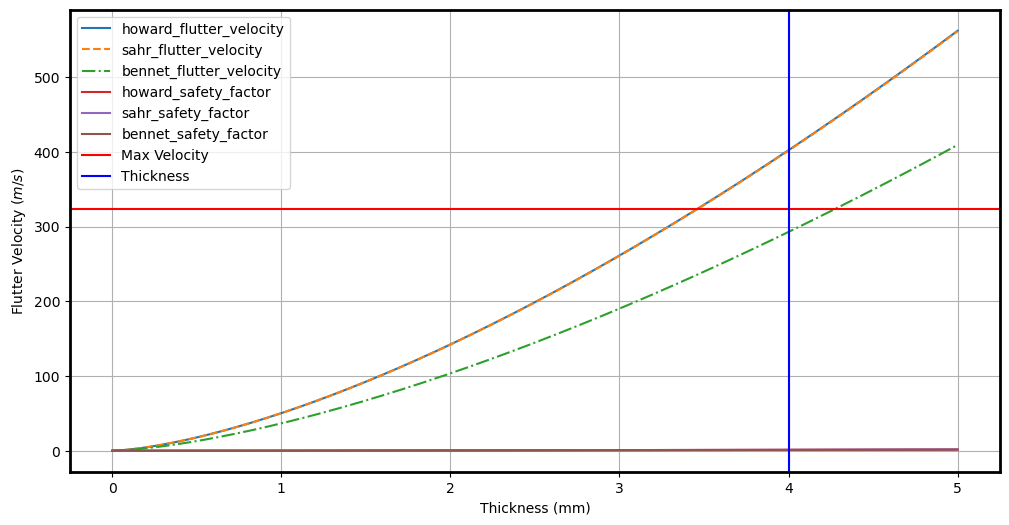

In [67]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel(r"Thickness (mm)")
ax1.set_ylabel(r"Flutter Velocity ($m/s$)")
ax1.grid(True)

# Define a dictionary of line styles for clarity
styles = {
    "howard_flutter_velocity": {"linestyle": "-"},  # solid line
    "sahr_flutter_velocity": {"linestyle": "--"},   # dashed line
    "bennet_flutter_velocity": {"linestyle": "-."}  # dash-dot line
}

# Iterate through the DataFrame columns to plot each flutter velocity, excluding 'thickness'
for column in flutter_df.columns:
    if column != "thickness":  # Ensure we only plot flutter velocity columns
        ax1.plot(flutter_df["thickness"], flutter_df[column], label=column,
                 **styles.get(column, {"linestyle": "-"}))  # Default to solid line if not specified

# Plotting Max Velocity and Thickness lines
ax1.axhline(y=MAX_VELOCITY, color='r', linestyle='-', label='Max Velocity')
ax1.axvline(x=THICKNESS, color='b', linestyle='-', label='Thickness')

# Adjusting spine properties
for spine in ax1.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(2)

# Showing the legend to distinguish between different flutter velocities
ax1.legend()

plt.show()


In [78]:
# Define the ranges for thickness and altitudes
thicknesses_array = np.linspace(0.01, 5, 100)  # Thickness from 0.01 to 5 with 50 points
altitude_range = np.linspace(0, 4000, 100)  # Altitude from 100 to 4000 with 50 points

# Initialize arrays to hold the data
howard_flutter_grid = np.zeros((len(thicknesses_array), len(altitude_range)))
sahr_flutter_grid = np.zeros_like(howard_flutter_grid)
bennet_flutter_grid = np.zeros_like(howard_flutter_grid)

# Perform calculations over the grid
for i, thickness in enumerate(thicknesses_array):
    for j, altitude in enumerate(altitude_range):
        # Update thickness and altitude in the parameters
        howard_params = params['howard_cfv']
        howard_params['thickness'] = thickness * MILLIMETRES_TO_INCHES if UNITS == 'SI' else thickness
        howard_params['altitude'] = altitude* METRES_TO_FEET if UNITS == 'SI' else altitude
        
        sahr_params = params['sahr_cfv']
        sahr_params['thickness'] = thickness
        sahr_params['altitude'] = altitude 
        
        bennet_params = params['bennet_cfv']
        bennet_params['t_val'] = thickness / 10
        bennet_params['h_val'] = altitude
        
        # Calculate flutter velocities
        howard_flutter_grid[i, j] = howard_cfv(**howard_params) / (METRES_TO_FEET if UNITS == 'SI' else 1)
        sahr_flutter_grid[i, j] = sahr_cfv(**sahr_params)
        bennet_flutter_grid[i, j] = bennet_cfv(**bennet_params)
        
        

# Calculate safety factors for each altitude and thickness
howard_safety_factors = howard_flutter_grid / MAX_VELOCITY
sahr_safety_factors = sahr_flutter_grid / MAX_VELOCITY
bennet_safety_factors = bennet_flutter_grid / MAX_VELOCITY

In [69]:
print(howard_flutter_grid[1,1])

1.6307229929775595


In [79]:
import pandas as pd

# Create a list to hold the data
safety_factors_data = []

# Loop over the grid and store the data
for i, thickness in enumerate(thicknesses_array):
    for j, altitude in enumerate(altitude_range):
        # Append a dictionary for each combination of thickness and altitude
        safety_factors_data.append({
            'Thickness': thickness,
            'Altitude': altitude,
            'Howard_Safety_Factor': howard_safety_factors[i, j],
            'Sahr_Safety_Factor': sahr_safety_factors[i, j],
            'Bennet_Safety_Factor': bennet_safety_factors[i, j]
        })

# Convert the list of dictionaries to a pandas DataFrame
safety_factors_df = pd.DataFrame(safety_factors_data)
display(safety_factors_df)
# Now safety_factors_df is a DataFrame where each row represents a unique combination of thickness and altitude
# and the corresponding safety factors for each flutter velocity calculation.


,Thickness,Altitude,Howard_Safety_Factor,Sahr_Safety_Factor,Bennet_Safety_Factor
0,0.01,0.000000,0.000134,0.000134,0.000097
1,0.01,40.404040,0.000134,0.000134,0.000098
2,0.01,80.808081,0.000134,0.000134,0.000098
3,0.01,121.212121,0.000135,0.000135,0.000098
4,0.01,161.616162,0.000135,0.000135,0.000098
...,...,...,...,...,...
9995,5.00,3838.383838,1.813695,1.808102,1.320539
9996,5.00,3878.787879,1.817546,1.811724,1.323348
9997,5.00,3919.191919,1.821408,1.815353,1.326165
9998,5.00,3959.595960,1.825282,1.818989,1.328990


In [80]:
# Create a 2D interactive plot with Plotly
fig = make_subplots(rows=1, cols=1)

# Function to update the traces based on the selected altitude
def create_traces_for_altitude(altitude_idx):
    return [
        go.Scatter(x=thicknesses_array, y=howard_flutter_grid[:, altitude_idx], mode='lines', name='Howard Flutter Velocity'),
        go.Scatter(x=thicknesses_array, y=sahr_flutter_grid[:, altitude_idx], mode='lines', name='Sahr Flutter Velocity'),
        go.Scatter(x=thicknesses_array, y=bennet_flutter_grid[:, altitude_idx], mode='lines', name='Bennet Flutter Velocity'),
    ]

# Add initial traces to the figure (for the first altitude)
initial_altitude_idx = 0
fig.add_traces(create_traces_for_altitude(initial_altitude_idx))

# Create the slider steps
steps = []
for i, altitude in enumerate(altitude_range):
    step = dict(
        method='update',
        args=[{'y': [
            howard_flutter_grid[:, i],
            sahr_flutter_grid[:, i],
            bennet_flutter_grid[:, i]
        ]}],
        label=f'{altitude:.0f} m'
    )
    steps.append(step)

# Add the slider to the figure
fig.update_layout(
    sliders=[{
        'active': initial_altitude_idx,
        'currentvalue': {'prefix': 'Altitude: '},
        'pad': {'t': 50},
        'steps': steps
    }],
    title='Flutter Velocity vs Thickness at Various Altitudes',
    xaxis_title='Thickness (mm)',
    yaxis_title='Flutter Velocity (m/s)'
)

# Show the figure
fig.show()

In [72]:
# Create a 2D interactive plot with Plotly for safety factors
safety_fig = make_subplots(rows=1, cols=1)

# Function to create traces for safety factors based on the selected altitude
def create_safety_factor_traces(altitude_idx):
    return [
        go.Scatter(x=thicknesses_array, y=howard_safety_factors[:, altitude_idx], mode='lines', name='Howard Safety Factor'),
        go.Scatter(x=thicknesses_array, y=sahr_safety_factors[:, altitude_idx], mode='lines', name='Sahr Safety Factor'),
        go.Scatter(x=thicknesses_array, y=bennet_safety_factors[:, altitude_idx], mode='lines', name='Bennet Safety Factor'),
    ]

# Add initial traces to the figure (for the first altitude)
initial_altitude_idx = 0
safety_fig.add_traces(create_safety_factor_traces(initial_altitude_idx))

# Create the slider steps for safety factors
safety_steps = []
for i, altitude in enumerate(altitude_range):
    step = dict(
        method='update',
        args=[{'y': [
            howard_safety_factors[:, i],
            sahr_safety_factors[:, i],
            bennet_safety_factors[:, i]
        ],
        'visible': [True, True, True]}],
        label=f'{altitude:.0f} m'
    )
    safety_steps.append(step)

# Add the slider to the safety factor figure
safety_fig.update_layout(
    sliders=[{
        'active': initial_altitude_idx,
        'currentvalue': {'prefix': 'Altitude: '},
        'pad': {'t': 50},
        'steps': safety_steps
    }],
    title='Safety Factor vs Thickness at Various Altitudes',
    xaxis_title='Thickness (mm)',
    yaxis_title='Safety Factor'
)

# Show the safety factor figure
safety_fig.show()


In [73]:
# safety_factor_normalized = (howard_safety_factors - np.min(howard_safety_factors)) / (np.max(howard_safety_factors) - np.min(howard_safety_factors))

# # Create the Plotly figure
# fig = go.Figure()

# # Add scatter plot for Howard Flutter Velocity with color indicating safety factor
# fig.add_trace(go.Scatter(
#     x=thicknesses_array, 
#     y=howard_flutter_grid[:, i],  # Assuming this is a 1D array for a specific altitude
#     mode='markers',
#     marker=dict(
#         color=howard_safety_factors,  # Use the normalized safety factor for color
#         size=10,
#         colorscale='Viridis',  # Ensure to use the same color scale as the color bar
#         colorbar=dict(title='Safety Factor'),
#         showscale=True
#     ),
#     name='Howard Flutter Velocity'
# ))

# # Update the layout of the figure
# fig.update_layout(
#     title='Flutter Velocity vs Thickness with Safety Factor as Color',
#     xaxis_title='Thickness (mm)',
#     yaxis_title='Flutter Velocity (m/s)'
# )

# # Show the figure
# fig.show()

In [74]:
# import plotly.graph_objs as go
# from plotly.subplots import make_subplots

# # Assuming the following variables are defined and calculated previously:
# # thicknesses_array, altitude_range
# # howard_flutter_grid, sahr_flutter_grid, bennet_flutter_grid
# # howard_safety_factors, sahr_safety_factors, bennet_safety_factors

# # Define the Plotly figure
# fig = make_subplots(rows=1, cols=1)

# # Function to update the traces and color based on the selected altitude
# def create_traces_for_altitude(altitude_idx):
#     # Normalize the safety factors for color mapping
#     howard_normalized_safety = (howard_safety_factors[:, altitude_idx] - np.min(howard_safety_factors)) / (np.max(howard_safety_factors) - np.min(howard_safety_factors))
#     sahr_normalized_safety = (sahr_safety_factors[:, altitude_idx] - np.min(sahr_safety_factors)) / (np.max(sahr_safety_factors) - np.min(sahr_safety_factors))
#     bennet_normalized_safety = (bennet_safety_factors[:, altitude_idx] - np.min(bennet_safety_factors)) / (np.max(bennet_safety_factors) - np.min(bennet_safety_factors))
    
#     traces = [
#         go.Scatter(
#             x=thicknesses_array, 
#             y=howard_flutter_grid[:, altitude_idx],
#             mode='lines',
#             marker=dict(
#                 color=howard_normalized_safety,
#                 colorscale='Viridis',
#                 showscale=True,
#                 colorbar=dict(title='Howard Safety Factor')
#             ),
#             name='Howard Flutter Velocity'
#         ),
#         go.Scatter(
#             x=thicknesses_array, 
#             y=sahr_flutter_grid[:, altitude_idx],
#             mode='lines',
#             marker=dict(
#                 color=sahr_normalized_safety,
#                 colorscale='Viridis',
#                 showscale=False
#             ),
#             name='Sahr Flutter Velocity'
#         ),
#         go.Scatter(
#             x=thicknesses_array, 
#             y=bennet_flutter_grid[:, altitude_idx],
#             mode='lines',
#             marker=dict(
#                 color=bennet_normalized_safety,
#                 colorscale='Viridis',
#                 showscale=False
#             ),
#             name='Bennet Flutter Velocity'
#         )
#     ]
    
#     return traces

# # Add initial traces to the figure (for the first altitude)
# initial_altitude_idx = 0
# fig.add_traces(create_traces_for_altitude(initial_altitude_idx))

# # Create the slider steps
# steps = []
# for i, altitude in enumerate(altitude_range):
#     step = dict(
#         method='update',
#         args=[{'y': [
#             howard_flutter_grid[:, i],
#             sahr_flutter_grid[:, i],
#             bennet_flutter_grid[:, i]
#         ], 'marker':[
#             dict(color=(howard_safety_factors[:, i] - np.min(howard_safety_factors)) / (np.max(howard_safety_factors) - np.min(howard_safety_factors))),
#             dict(color=(sahr_safety_factors[:, i] - np.min(sahr_safety_factors)) / (np.max(sahr_safety_factors) - np.min(sahr_safety_factors))),
#             dict(color=(bennet_safety_factors[:, i] - np.min(bennet_safety_factors)) / (np.max(bennet_safety_factors) - np.min(bennet_safety_factors)))
#         ]}],
#         label=f'{altitude:.0f} m'
#     )
#     steps.append(step)

# # Add the slider to the figure
# fig.update_layout(
#     sliders=[{
#         'active': initial_altitude_idx,
#         'currentvalue': {'prefix': 'Altitude: '},
#         'pad': {'t': 50},
#         'steps': steps
#     }],
#     title='Flutter Velocity vs Thickness at Various Altitudes',
#     xaxis_title='Thickness (mm)',
#     yaxis_title='Flutter Velocity (m/s)'
# )

# # Show the figure
# fig.show()


In [75]:
# # Define the Plotly figure
# fig = make_subplots(rows=1, cols=1)

# # Function to update the traces and color based on the selected altitude
# def create_traces_for_altitude(altitude_idx):
#     # Normalize the safety factors for color mapping
#     howard_colorscale = (howard_safety_factors[:, altitude_idx] - np.min(howard_safety_factors)) / (np.max(howard_safety_factors) - np.min(howard_safety_factors))
    
#     return [
#         go.Scatter(
#             x=thicknesses_array, 
#             y=howard_flutter_grid[:, altitude_idx],
#             mode='lines+markers',
#             marker=dict(
#                 size=8,
#                 color=howard_colorscale,  # Apply the normalized safety factors as color
#                 colorscale='Viridis',  # Color scale for safety factor
#                 showscale=True,  # Show color scale
#                 colorbar=dict(title='Safety Factor')
#             ),
#             line=dict(color='rgba(0,0,0,0)'),  # Hide the line to show only markers
#             name='Howard Flutter Velocity'
#         )
#         # Add similar traces for sahr_flutter_grid and bennet_flutter_grid if needed
#     ]

# # Add initial traces to the figure (for the first altitude)
# initial_altitude_idx = 0
# fig.add_traces(create_traces_for_altitude(initial_altitude_idx))

# # Create the slider steps
# steps = []
# for i, altitude in enumerate(altitude_range):
#     howard_colorscale = (howard_safety_factors[:, i] - np.min(howard_safety_factors)) / (np.max(howard_safety_factors) - np.min(howard_safety_factors))
    
#     step = dict(
#         method='update',
#         args=[{'y': [howard_flutter_grid[:, i]],
#                'marker': [{'color': howard_colorscale, 'size': 8}]
#               }],
#         label=f'{altitude:.0f} m'
#     )
#     steps.append(step)

# # Add the slider to the figure
# fig.update_layout(
#     sliders=[{
#         'active': initial_altitude_idx,
#         'currentvalue': {'prefix': 'Altitude: '},
#         'pad': {'t': 50},
#         'steps': steps
#     }],
#     title='Flutter Velocity vs Thickness at Various Altitudes',
#     xaxis_title='Thickness (mm)',
#     yaxis_title='Flutter Velocity (m/s)'
# )
# # Create a slider widget for altitude
# altitude_slider = widgets.IntSlider(
#     value=0,
#     min=0,
#     max=len(altitude_range) - 1,
#     step=1,
#     description='Altitude Index:',
#     continuous_update=False
# )

# # Use the `interactive` function to bind the widget to the update plot function
# widgets.interactive(update_plot, altitude_index=altitude_slider)
# # Show the figure
# fig.show()

In [76]:
# # Function to create the plot with the updated safety factor based on the selected altitude index
# def update_plot(altitude_index):
#     # Calculate the safety factors for the selected altitude
#     safety_factors = howard_flutter_grid[:, altitude_index] / MAX_VELOCITY

#     # Create a color scale based on the actual safety factor values
#     colors = safety_factors - np.min(safety_factors)  # Shift color scale if needed
#     colors = colors / np.max(colors)  # Normalize to 0-1 range for color scale mapping

#     # Create the new plot
#     fig = go.Figure()
#     fig.add_trace(go.Scatter(
#         x=thicknesses_array, 
#         y=howard_flutter_grid[:, altitude_index],
#         mode='markers',
#         marker=dict(
#             size=8,
#             color=colors,  # Use the shifted safety factor values for color
#             colorscale='Viridis',
#             cmin=np.min(safety_factors),  # Set the minimum for the color scale
#             cmax=np.max(safety_factors),  # Set the maximum for the color scale
#             colorbar=dict(title='Safety Factor'),
#             showscale=True
#         ),
#         name='Howard Flutter Velocity'
#     ))

#     # Set the layout for the new plot
#     fig.update_layout(
#         title=f'Flutter Velocity vs Thickness at Altitude: {altitude_range[altitude_index]:.0f} m',
#         xaxis_title='Thickness (mm)',
#         yaxis_title='Flutter Velocity (m/s)'
#     )

#     # Display the new plot in the notebook
#     fig.show()

# # Create a slider widget for altitude
# altitude_slider = widgets.IntSlider(
#     value=0,
#     min=0,
#     max=len(altitude_range) - 1,
#     step=1,
#     description='Altitude Index:',
#     continuous_update=False
# )

# # Use the `interactive` function to bind the widget to the update plot function
# widgets.interactive(update_plot, altitude_index=altitude_slider)

In [81]:
# Function to create the plot with the updated safety factor based on the selected altitude index
def update_plot(altitude_index):
    # Get the current altitude from the altitude range
    current_altitude = altitude_range[altitude_index]
    
    # Filter the DataFrame for the current altitude
    current_data = safety_factors_df[safety_factors_df['Altitude'] == current_altitude]
    
    # Create the new plot
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=current_data['Thickness'], 
        y=howard_flutter_grid[:, altitude_index],  # Replace with actual velocity data if different
        mode='markers',
        marker=dict(
            size=8,
            color=current_data['Howard_Safety_Factor'],  # Use the safety factor values for color
            colorscale='Viridis',
            colorbar=dict(title='Safety Factor'),
            showscale=True
        ),
        name='Howard Flutter Velocity'
    ))

    # Set the layout for the new plot
    fig.update_layout(
        title=f'Flutter Velocity vs Thickness at Altitude: {current_altitude:.0f} m',
        xaxis_title='Thickness (mm)',
        yaxis_title='Flutter Velocity (m/s)'
    )

    # Display the new plot in the notebook
    fig.show()

# Create a slider widget for altitude
altitude_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(altitude_range) - 1,
    step=1,
    description='Altitude Index:',
    continuous_update=False
)

# Use the `interactive` function to bind the widget to the update plot function
widgets.interactive(update_plot, altitude_index=altitude_slider)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Altitude Index:', max=99), Outp…

In [82]:
# Define the ranges for thickness and altitudes using NumPy's broadcasting
thicknesses_array = np.linspace(0.01, 5, 100).reshape(-1, 1)  # Convert to column vector
altitude_range = np.linspace(0, 4000, 100)  # Keep as is for broadcasting

# Perform calculations using broadcasting and vectorized operations
thickness_in_inches = thicknesses_array * MILLIMETRES_TO_INCHES if UNITS == 'SI' else thicknesses_array
altitude_in_feet = altitude_range * METRES_TO_FEET if UNITS == 'SI' else altitude_range

# Assuming the calculation functions are vectorized and can accept arrays
howard_flutter_grid = howard_cfv(thickness_in_inches, altitude_in_feet) / (METRES_TO_FEET if UNITS == 'SI' else 1)
sahr_flutter_grid = sahr_cfv(thickness_in_inches, altitude_in_feet)
bennet_flutter_grid = bennet_cfv(thickness_in_inches / 10, altitude_in_feet)

# Calculate safety factors for each altitude and thickness using vectorized division
howard_safety_factors = howard_flutter_grid / MAX_VELOCITY
sahr_safety_factors = sahr_flutter_grid / MAX_VELOCITY
bennet_safety_factors = bennet_flutter_grid / MAX_VELOCITY

TypeError: calculate_flutter_velocity() missing 4 required positional arguments: 'thickness', 'root_chord', 'tip_chord', and 'semispan'